## Time Series Forecasting in R

Since it was very clumsy to perform time series forecasting in python, I decided to try the R forecasting package in R (via the R kernel in Jupyter notebooks).

I saved my time glucose time grid data as a csv, so to begin I will import it into an R dataframe.

In [2]:
library(forecast)

In [3]:
#Load file (not a csv technically)
glucTimeTable <- read.table('diabetes_analysis_glucTimeGrid', 
                            header=TRUE, sep= ',')

In [4]:
#Get data type
typeof(glucTimeTable)

[1] "list"

In [5]:
#Turn list into a dataframe and get the first couple of rows
data= data.frame(glucTimeTable)
head(data)

X,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X61,X62,X63,X64,X65,X67,X68,X69,X70,dates
0,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,158.0,NA,NA,1988-03-27
1,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,135.0,NA,NA,1988-03-28
2,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,147.0,NA,NA,1988-03-31
3,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,136.0,NA,NA,1988-04-02
4,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,111.5,NA,NA,1988-04-04
5,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,140.0,NA,NA,1988-04-06


In [6]:
#Remove first column from dataframe
x1= data$X1

In [7]:
#Remove the nans 
x1= x1[!is.na(x1)]


In [23]:
#Let's check the length of our non-nan list
print(length(x1))

#Calc 80% boundary
trainBound= round(length(x1)*0.8)
print(trainBound)

[1] 136
[1] 109


In [30]:
#Split into training and testing sets
train= x1[1:trainBound]
test= tail(x1, -trainBound)

print(length(train))
print(length(test))

[1] 109
[1] 27


In [10]:
help(':')

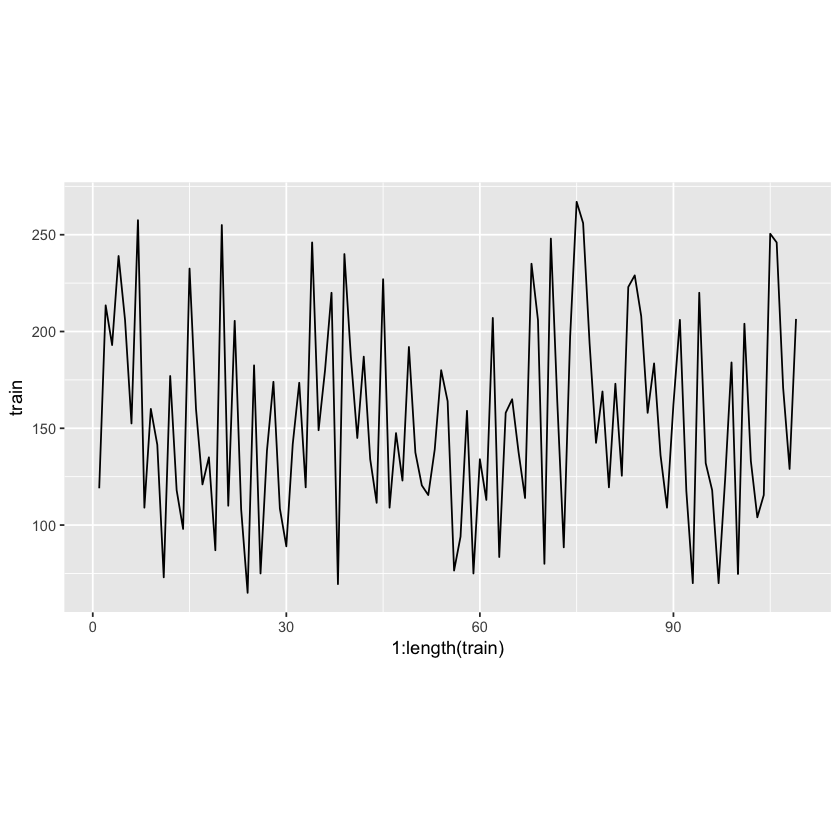

In [31]:
#Load ggplot and plot a line of our first column (subject 1)
library(ggplot2)
linePlot= qplot(1:length(train),train, geom= 'line')
linePlot + coord_fixed(ratio= 0.3)

### STL Decomposition

Here I will quickly remake the plots I made in the python notebook. First I'll remake the season trend, irregular/remainder plot.

In [38]:
#Convert vector to a time series object
tsTrain= ts(train, frequency= 7)

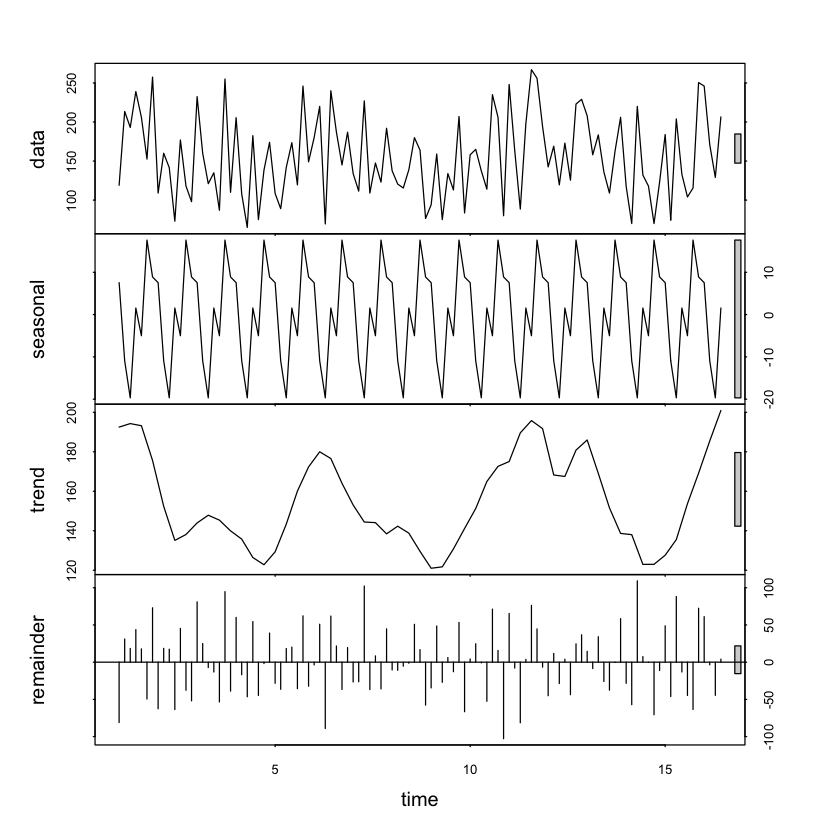

In [41]:
#Define parameters for season (s) and trend (t) for a fit
fit= stl(tsTrain, s.window= 'periodic', robust=TRUE)

#Decomposed time series
plot(fit)

This trend looks different than what I got in my python code (manually and using statsmodels.tsa.seasonal_decompose). The seasonal component looks similar though. How's it calculating these? I think that problem could be with how I defined tsX1 but I'm just telling it the frequency is 7 which should be ok...another source for problem could be if it's doing a multiplicative decomposition instead of additive. An example of this package [here](https://www.r-bloggers.com/time-series-decomposition/).

<strong>Edit:</strong>: Ok, found main problem! I forgot that in Python I had split my dataset into train and test, but hadn't done so here. Now that I've changed that they look a lot more similar

## Forecasting